In [1]:
import os
import copy
import numpy as np
import pandas as pd
from PIL import Image, ImageFile

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from transformers import CLIPProcessor, CLIPModel
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

d:\Anaconda\envs\Hatememes\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.加载和清理数据

In [2]:
# 我们允许截断的图像，以防万一
ImageFile.LOAD_TRUNCATED_IMAGES = True

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用设备:", DEVICE)

CSV_PATH = "./memotion_dataset_7k/labels.csv"
IMAGES_DIR = "./memotion_dataset_7k/images"

df = pd.read_csv(CSV_PATH,index_col=0)
print("数据集大小:", df.shape)
print("数据集列:", df.columns)
print("数据集信息:\n", df.info())
print("数据集前几行:\n", df.head())

使用设备: cuda
数据集大小: (6992, 8)
数据集列: Index(['image_name', 'text_ocr', 'text_corrected', 'humour', 'sarcasm',
       'offensive', 'motivational', 'overall_sentiment'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 6992 entries, 0 to 6991
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_name         6992 non-null   object
 1   text_ocr           6831 non-null   object
 2   text_corrected     6987 non-null   object
 3   humour             6992 non-null   object
 4   sarcasm            6992 non-null   object
 5   offensive          6992 non-null   object
 6   motivational       6992 non-null   object
 7   overall_sentiment  6992 non-null   object
dtypes: object(8)
memory usage: 491.6+ KB
数据集信息:
 None
数据集前几行:
      image_name                                           text_ocr  \
0   image_1.jpg  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   
1  image_2.jpeg  The best of #10 YearCh

In [3]:
# 删除text_corrected或者offensive列中有空值的行
df = df.dropna(subset=["text_corrected", "offensive"])
# 将文本列强制转为字符串类型，避免可能的数值类型或空对象导致的错误
df["text_corrected"] = df["text_corrected"].astype(str)
# 去除文本中全是空白字符的行
df = df[df["text_corrected"].str.strip() != ""]

print("处理后的数据集大小:", df.shape)

处理后的数据集大小: (6987, 8)


In [4]:
# 验证图像，跳过任何完全损坏的图像
bad_images = 0
valid_indices = []

for i, row in df.iterrows():
    img_path = os.path.join(IMAGES_DIR, row["image_name"])
    try:
        with Image.open(img_path) as im:
            im.verify()
        valid_indices.append(i)        
    except Exception as e:
        bad_images += 1
        print(f"损坏文件: {img_path}, 错误: {str(e)}") 
   
df = df.loc[valid_indices].reset_index(drop=True)
print(f"跳过了 {bad_images} 张损坏的图像，有效图像数量: {len(df)}")

损坏文件: ./memotion_dataset_7k/images\image_5119.png, 错误: Truncated File Read
跳过了 1 张损坏的图像，有效图像数量: 6986


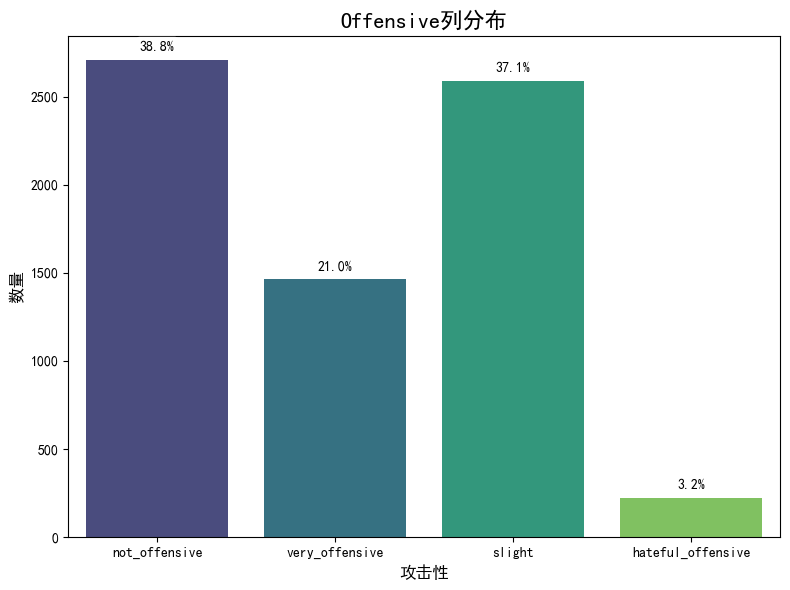

In [5]:
# 显示数据集的分布
plt.figure(figsize=(8, 6))
sns.countplot(x="offensive", data=df, palette="viridis")
plt.title("Offensive列分布", fontsize=16)
plt.xlabel("攻击性", fontsize=12)
plt.ylabel("数量", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# 在图上添加百分比
for p in plt.gca().patches:
    percentage = f"{p.get_height() / len(df) * 100:.1f}%"
    plt.annotate(percentage, 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black', 
                 rotation=0, xytext=(0, 5), textcoords='offset points',
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.7))
plt.tight_layout()

plt.savefig("./images_draw/offensive_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
df[['image_name','text_corrected','offensive']].head(5)

,image_name,text_corrected,offensive
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,not_offensive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_offensive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,not_offensive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_offensive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,very_offensive


In [9]:
# 将原始的4个类别合并为2个类别（offensive, not_offensive）
def merge_offensive(label):
    if label in ["slight", "very_offensive",'hateful_offensive']:
        return "offensive"
    else:
        return "not_offensive"

# 合并标签
df["merge_offensive"] = df["offensive"].apply(merge_offensive)
label2id = {"not_offensive": 0, "offensive": 1}
df["label"] = df["merge_offensive"].map(label2id)
print("Merged distribution:")
print(df["merge_offensive"].value_counts(normalize=True))

Merged distribution:
merge_offensive
offensive        0.612081
not_offensive    0.387919
Name: proportion, dtype: float64


In [10]:
df[['image_name','text_corrected','offensive','merge_offensive','label']].head(5)

,image_name,text_corrected,offensive,merge_offensive,label
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,not_offensive,not_offensive,0
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_offensive,not_offensive,0
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,not_offensive,not_offensive,0
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_offensive,offensive,1
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,very_offensive,offensive,1


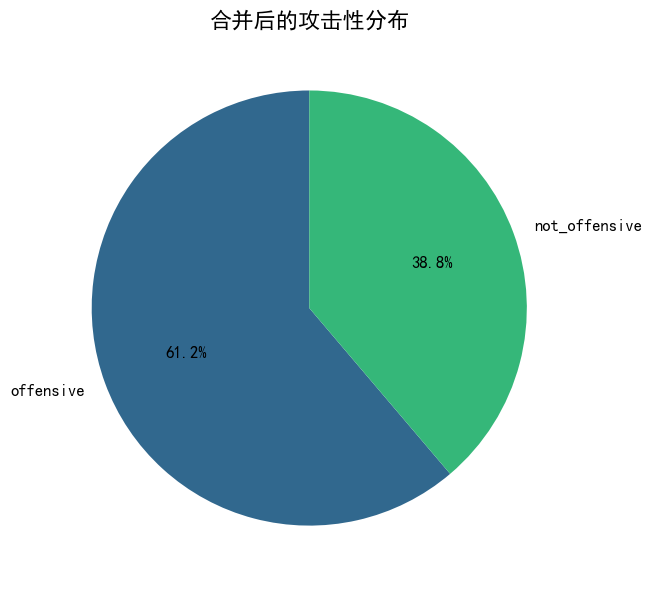

In [11]:
# 画饼图可视化分布
plt.figure(figsize=(8, 6))
df["merge_offensive"].value_counts().plot.pie(
    autopct="%1.1f%%", 
    startangle=90, 
    colors=sns.color_palette("viridis", len(df["merge_offensive"].unique())),
    labels=["offensive", "not_offensive"], 
    textprops={'fontsize': 12}
)
plt.title("合并后的攻击性分布", fontsize=16)
plt.ylabel("")  # 去掉默认的y轴标签
plt.tight_layout()
# 保存图像
plt.savefig("./images_draw/merged_offensive_distribution_pie.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:

# 将数据集按标签分层拆分为训练集和测试集，测试集占15%
train_df, test_df = train_test_split(
    df, test_size=0.15, stratify=df["label"], random_state=42
)  

# 将测试集进一步按标签分层拆分为验证集和测试集，各占50%
val_df, test_df = train_test_split(
    test_df, test_size=0.5, stratify=test_df["label"], random_state=42
)  

print("训练集/验证集/测试集大小:", len(train_df), len(val_df), len(test_df))

训练集/验证集/测试集大小: 5938 524 524


Train分布:
 label
1    3635
0    2303
Name: count, dtype: int64
Val分布:
 label
1    321
0    203
Name: count, dtype: int64
Test分布:
 label
1    320
0    204
Name: count, dtype: int64


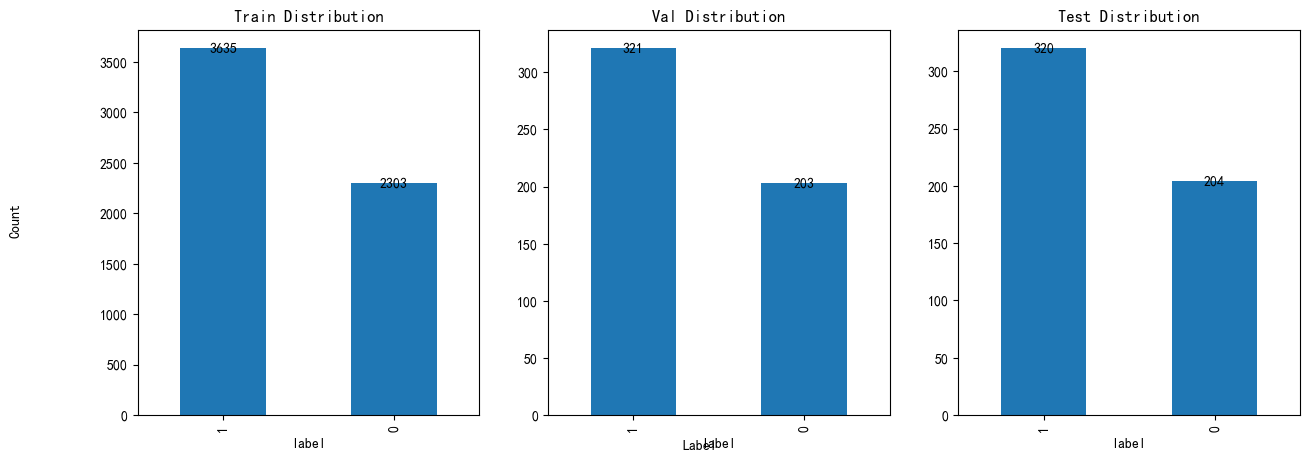

In [15]:
# 检查数据分布,在划分后打印各子集的类别分布，确保少数类样本足够
print("Train分布:\n", train_df["label"].value_counts())
print("Val分布:\n", val_df["label"].value_counts())
print("Test分布:\n", test_df["label"].value_counts())

# 绘制了每个子集中两类样本的数量柱状图，进一步说明类别比例一致性

train_distribution = train_df["label"].value_counts()
val_distribution = val_df["label"].value_counts()
test_distribution = test_df["label"].value_counts()

# 创建一个包含三个子图的画布
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 绘制训练集的柱状图
train_distribution.plot(kind='bar', ax=axes[0], title='Train Distribution')
for p in axes[0].patches:
    axes[0].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')

# 绘制验证集的柱状图
val_distribution.plot(kind='bar', ax=axes[1], title='Val Distribution')
for p in axes[1].patches:
    axes[1].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')

# 绘制测试集的柱状图
test_distribution.plot(kind='bar', ax=axes[2], title='Test Distribution')
for p in axes[2].patches:
    axes[2].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')

# 设置全局的 X 轴标签
fig.text(0.5, 0.04, 'Label', ha='center')
# 设置全局的 Y 轴标签
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')

# 显示图形
plt.show()


In [14]:
# # 下载模型
# from huggingface_hub import snapshot_download

# clip_model_name = "openai/clip-vit-base-patch32"
# local_dir = "D:/clip-vit-base-patch32"  
# snapshot_download(repo_id=clip_model_name, local_dir=local_dir)

In [15]:
# 5) CLIP 处理器

# 我们将使用 openai/clip-vit-base-patch32 模型的变体
clip_model_name = "openai/clip-vit-base-patch32"
local_dir = "D:/clip-vit-base-patch32"  

# 从本地目录加载 CLIP 处理器
processor = CLIPProcessor.from_pretrained(local_dir)

# 该处理器将自动处理图像的变换和文本的分词
# 我们将在自定义数据集中应用它


In [16]:
# 6) 自定义数据集

class CLIPMemotionDataset(Dataset):
    """
    每个样本返回：
      - pixel_values: 转换后的图像张量
      - input_ids, attention_mask: 分词后的文本
      - label: 攻击性类别
    """
    def __init__(self, dataframe, images_dir, processor, max_length=77):
        self.df = dataframe.reset_index(drop=True)  # 重置索引，确保数据一致性
        self.images_dir = images_dir  
        self.processor = processor  # CLIP 处理器
        self.max_length = max_length  # 文本最大长度

    def __len__(self):
        return len(self.df) 

    def __getitem__(self, idx):
        row = self.df.iloc[idx]  # 获取指定索引的行数据
        img_path = os.path.join(self.images_dir, row["image_name"])  # 获取图像路径
        image = Image.open(img_path).convert("RGB")  # 打开图像并转换为RGB格式
        text = row["text_corrected"]  # 获取文本
        label = torch.tensor(row["label"], dtype=torch.long)  # 获取标签并转换为张量

        # CLIP处理器可以同时处理图像和文本，但为了清晰，我们分开调用
        encoded = self.processor(
            text=[text],  # 文本输入
            images=[image],  # 图像输入
            padding="max_length",  # 填充到最大长度
            truncation=True,  # 截断超长文本
            max_length=self.max_length,  # 最大长度
            return_tensors="pt"  # 返回PyTorch张量
        )

        # encoded 是一个包含 pixel_values, input_ids, attention_mask 的字典
        # 去掉batch维度（默认batch=1），返回普通张量
        pixel_values = encoded["pixel_values"].squeeze(0)       # [3, 224, 224]
        input_ids = encoded["input_ids"].squeeze(0)             # [max_length]
        attention_mask = encoded["attention_mask"].squeeze(0)   # [max_length]

        return {
            "pixel_values": pixel_values,  # 图像张量
            "input_ids": input_ids,        # 文本ID
            "attention_mask": attention_mask,  # 注意力掩码
            "label": label                 # 标签
        }



In [19]:
# 7) CLIP 分类模型

class CLIPClassifier(nn.Module):
    """
    包装一个 CLIPModel，并添加一个用于二分类的小型分类器。
    我们将：
      - 从模型输出中获取 image_embeds（图像嵌入）
      - 从模型输出中获取 text_embeds（文本嵌入）
      - 将它们结合起来，然后通过一个小型前馈网络
    """
    def __init__(self, model_name, num_labels=2, freeze_clip=False):
        super().__init__()
        self.clip_model = CLIPModel.from_pretrained(model_name)
        self.num_labels = num_labels

        # 可选：冻结整个 CLIP 模型以减少内存使用并避免大规模更新
        if freeze_clip:
            for param in self.clip_model.parameters():
                param.requires_grad = False

        embed_dim = self.clip_model.config.projection_dim * 2  # 例如，512 + 512 = 1024
        # 添加一个小型分类器头
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_labels)
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        # CLIP 的前向传播：
        # 返回 image_embeds（图像嵌入）、text_embeds（文本嵌入）等
        outputs = self.clip_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        # outputs.image_embeds: [batch_size, projection_dim] 默认=512
        # outputs.text_embeds:  [batch_size, projection_dim]

        # 默认情况下，CLIPModel 输出的嵌入已经是归一化的（单位球面）
        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds

        # 将它们拼接起来用于分类
        fused = torch.cat([image_embeds, text_embeds], dim=1)  # 形状: [B, 1024]
        logits = self.classifier(fused)
        return logits

num_labels = 2
model = CLIPClassifier(
    model_name=clip_model_name, 
    num_labels=num_labels, 
    freeze_clip=False  
).to(DEVICE)

In [ ]:
# class ImprovedCLIPClassifier(nn.Module):
#     def __init__(self, model_name, num_labels=2):
#         super().__init__()
#         self.clip_model = CLIPModel.from_pretrained(model_name)
        
#         # 分层冻结
#         self._freeze_base_layers()
        
#         embed_dim = self.clip_model.config.projection_dim
        
#         # 多头注意力融合
#         self.cross_attention = nn.MultiheadAttention(embed_dim, 8, batch_first=True)
        
#         # 改进的分类器头
#         self.classifier = nn.Sequential(
#             nn.Linear(embed_dim, 512),
#             nn.LayerNorm(512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 256),
#             nn.LayerNorm(256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, num_labels)
#         )
    
#     def _freeze_base_layers(self):
#         # 冻结底层特征提取器
#         for name, param in self.clip_model.named_parameters():
#             if 'visual.transformer.resblocks' in name:
#                 layer_num = int(name.split('.')[3])
#                 if layer_num < 8:  # 只冻结前8层
#                     param.requires_grad = False

#### SMOTE处理

In [22]:
def extract_features(df, images_dir, processor):
    """提取多模态特征（保持在GPU）"""
    features = []
    model.clip_model.eval()  # 确保模型处于评估模式
    with torch.no_grad():
        for _, row in df.iterrows():
            img_path = os.path.join(images_dir, row["image_name"])
            image = Image.open(img_path).convert("RGB")
            text = row["text_corrected"]
            
            # 处理输入并移动到GPU
            inputs = processor(
                text=[text], 
                images=[image], 
                return_tensors="pt", 
                padding=True, 
                truncation=True
            ).to(DEVICE)  # 一次性移动到GPU
            
            # 前向传播
            outputs = model.clip_model(**inputs)
            fused_feature = torch.cat([outputs.image_embeds, outputs.text_embeds], dim=1)
            features.append(fused_feature.squeeze(0))
    return torch.stack(features)  # 返回GPU张量

# 提取特征（保持在GPU）
X_train = extract_features(train_df, IMAGES_DIR, processor)  # shape: [N, 1024]
y_train = train_df["label"].values

# 应用SMOTE前将特征移到CPU（SMOTE需NumPy输入）
X_train_cpu = X_train.cpu().numpy()
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_cpu, y_train)


In [ ]:
# 重建过采样后的训练集DataFrame
# 注意：SMOTE生成的是合成样本，需映射回原始数据格式（此处需特殊处理）
# 由于无法直接生成新图像和文本，这里采用“重复样本”近似替代
_, counts = np.unique(y_train, return_counts=True)
n_to_add = len(X_train_res) - len(X_train)
minority_class = 1 if counts[1] < counts[0] else 0
minority_samples = train_df[train_df["label"] == minority_class]

# 重复少数类样本以匹配SMOTE后的数量
repeat_times = n_to_add // len(minority_samples) + 1
oversampled_minority = pd.concat([minority_samples] * repeat_times, ignore_index=True)
oversampled_minority = oversampled_minority.sample(n=n_to_add, random_state=42)

# 合并原始训练集和过采样样本
train_df_resampled = pd.concat([train_df, oversampled_minority], ignore_index=True)

print("过采样后训练集分布:\n", train_df_resampled["label"].value_counts())

过采样后训练集分布:
 label
1    3635
0    3635
Name: count, dtype: int64


In [24]:
# 创建训练集、验证集和测试集的数据集对象
train_dataset = CLIPMemotionDataset(train_df, IMAGES_DIR, processor)
val_dataset   = CLIPMemotionDataset(val_df,   IMAGES_DIR, processor)
test_dataset  = CLIPMemotionDataset(test_df,  IMAGES_DIR, processor)

# 定义批量大小
BATCH_SIZE = 8

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  # 训练集打乱顺序
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False) # 验证集不打乱
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False) # 测试集不打乱

# 重新创建过采样后的训练集Dataset
train_dataset_resampled = CLIPMemotionDataset(train_df_resampled, IMAGES_DIR, processor)
train_loader_resampled = DataLoader(train_dataset_resampled, batch_size=BATCH_SIZE, shuffle=True)

In [25]:
# 8) 优化器 / 学习率调度器

# 微调 CLIP 可能会非常耗费资源。我们使用一个较小的学习率。
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# 尝试了简单的调度器和 ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=1, verbose=True
)

# 计算类别权重以平衡类别不均衡
class_weights = compute_class_weight(
    'balanced', 
    classes=np.array([0, 1]), 
    y=train_df["label"]
)

# 确保权重张量在正确的设备上
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [ ]:
# 9) 训练 / 评估函数
def epoch_step(model, dataloader, is_train=False):
    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in dataloader:
        pixel_values = batch["pixel_values"].to(DEVICE)
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        if is_train:
            optimizer.zero_grad()

        logits = model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        loss = criterion(logits, labels)
        total_loss += loss.item() * labels.size(0)

        preds = logits.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.detach().cpu().numpy())

        if is_train:
            loss.backward()
            optimizer.step()

    avg_loss = total_loss / len(dataloader.dataset)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")
    return avg_loss, acc, prec, rec, f1

In [30]:
# 10) 训练循环（带早停机制）
# 增加时间计时
import time
start_time = time.time()
print("开始训练...")

EPOCHS = 5
patience = 2
best_val_loss = float("inf")
no_improve = 0
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc, train_prec, train_rec, train_f1 = epoch_step(model, train_loader_resampled, is_train=True)
    val_loss, val_acc, val_prec, val_rec, val_f1 = epoch_step(model, val_loader, is_train=False)

    # 根据验证集损失调整学习率
    scheduler.step(val_loss)

    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | P: {train_prec:.4f} | R: {train_rec:.4f} | F1: {train_f1:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}   | Acc: {val_acc:.4f}   | P: {val_prec:.4f} | R: {val_rec:.4f} | F1: {val_f1:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        best_state = copy.deepcopy(model.state_dict())
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break
# 结束时间
end_time = time.time()
print(f"训练完成，总耗时: {end_time - start_time:.2f}秒")
# 加载最佳模型状态
model.load_state_dict(best_state)

# 保存模型最佳状态
model_save_path = "./clip_memotion_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"模型已保存到: {model_save_path}")



开始训练...

Epoch 1/5
  Train Loss: 0.6571 | Acc: 0.5684 | P: 0.5985 | R: 0.5684 | F1: 0.5326
  Val   Loss: 0.7631   | Acc: 0.3893   | P: 0.4386 | R: 0.4690 | F1: 0.3493

Epoch 2/5
  Train Loss: 0.5732 | Acc: 0.7199 | P: 0.7280 | R: 0.7199 | F1: 0.7175
  Val   Loss: 0.7827   | Acc: 0.4752   | P: 0.4637 | R: 0.4621 | F1: 0.4610

Epoch 3/5
  Train Loss: 0.4563 | Acc: 0.8287 | P: 0.8300 | R: 0.8287 | F1: 0.8286
  Val   Loss: 0.8602   | Acc: 0.5000   | P: 0.4660 | R: 0.4670 | F1: 0.4661
Early stopping triggered.
训练完成，总耗时: 609.79秒
模型已保存到: ./clip_memotion_model.pth


In [ ]:
if best_state:
    model.load_state_dict(best_state)

# Final Test

test_loss, test_acc, test_prec, test_rec, test_f1 = epoch_step(model, test_loader, is_train=False)
print("\n--- CLIP Test Results ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc:  {test_acc:.4f}")
print(f"Macro Precision: {test_prec:.4f}")
print(f"Macro Recall:    {test_rec:.4f}")
print(f"Macro F1:        {test_f1:.4f}")


--- CLIP Test Results ---
Test Loss: 0.6303
Test Acc:  0.6190
Macro Precision: 0.7059
Macro Recall:    0.6190
Macro F1:        0.5740
